## <font color='5499C7'>Data </font> 



#### <font color='5499C7'>data files </font> 

* 

####  <font color='5499C7'>Description of the Fields </font> 


* 


## <font color='5499C7'> Importing libraries</font> 


In [ ]:
import zipfile
from pathlib import Path
import pandas as pd
import os
import numpy as np 
import math
from PIL import Image
import urllib.request
from multiprocessing.pool import ThreadPool


pd.set_option('display.max_columns', None)



## <font color='5499C7'> Precomputed Data</font> 

In [ ]:
#  unzip all images from the Unsplash dataset

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/project2/data/images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion') #Extracts the files into the folder
zip_ref.close()



#### Loading the datasets in Pandas

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion'


#####a reduced resolution (640 pixels width), because they are downscaled by CLIP anyway.

In [ ]:

import os
from os import listdir
from PIL import Image

basewidth = 640

# get the path/directory
folder_dir = "/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion/images"
for images in os.listdir(folder_dir):
  
  f_img = folder_dir+"/"+images 

  img = Image.open(f_img)
  wpercent = (basewidth / float(img.size[0]))
  hsize = int((float(img.size[1]) * float(wpercent)))
  img = img.resize((basewidth, hsize), Image.ANTIALIAS)
  img.save('/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion/photos/'+images)

In [ ]:
#!rm -rf "/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion/features"


## <font color='5499C7'> Now for we can start from here using CLIP</font> 


##### Setup Environment

In [ ]:
#install CLIP and then make sure that we have torch 1.7.1 with CUDA support.

!pip install git+https://github.com/openai/CLIP.git
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2qh2e4h0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-2qh2e4h0
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 2.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=b7c482a305d806d61a92b166f0dd403165ba86ed7bebd4ba2af7db9aef825e48
  Stored in directory: /tmp/pip-ephem-wheel-cache-2zaixij2/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# load CLIP 
import clip
import torch

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 127MiB/s]


##### feature vector

In [ ]:
#For each image we get a feature vector containing 512 float numbers, which we will store in a file. 
#These feature vectors will be used later to compare them to the text feature vectors.

photos_path = "/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion/photos"

# List .jpg  in photos Folder 
photos_files = list(Path(photos_path).glob('*.jpg'))


# Print number of photos 
print(f"Photos found: {len(photos_files)}")

Photos found: 44096


In [ ]:
# Function that computes the feature vectors for a batch of images
def compute_clip_features(photos_batch):
    # Load all the photos from the files
    photos = [Image.open(photo_file) for photo_file in photos_batch]
    
    # Preprocess all photos
    photos_preprocessed = torch.stack([preprocess(photo) for photo in photos]).to(device)

    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = model.encode_image(photos_preprocessed)
        photos_features /= photos_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()

In [ ]:
#compute the features for all photos. 
# feature vectors and the photo IDs of each batch will be saved to a file separately. 
#will merge the data later.


# Define the batch size so that it fits on your GPU. You can also do the processing on the CPU, but it will be slower.
batch_size = 200

# Path where the feature vectors will be stored
features_path = "/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion/features"

# Compute how many batches are needed
batches = math.ceil(len(photos_files) / batch_size)

# Process each batch
for i in range(batches):
    print(f"Processing batch {i+1}/{batches}")

    batch_ids_path = features_path +"/" +f"{i:010d}.csv"
    batch_features_path = features_path+"/" + f"{i:010d}.npy"
    
    # Only do the processing if the batch wasn't processed yet
     
    if not os.path.exists(batch_features_path):
        try:
            # Select the photos for the current batch
            batch_files = photos_files[i*batch_size : (i+1)*batch_size]

            # Compute the features and save to a numpy file
            batch_features = compute_clip_features(batch_files)
            np.save(batch_features_path, batch_features)

            # Save the photo IDs to a CSV file
            photo_ids = [photo_file.name.split(".")[0] for photo_file in batch_files]
            photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
            photo_ids_data.to_csv(batch_ids_path, index=False)
        except:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i}')


Processing batch 1/221
Processing batch 2/221
Processing batch 3/221
Processing batch 4/221
Processing batch 5/221
Processing batch 6/221
Processing batch 7/221
Processing batch 8/221
Processing batch 9/221
Processing batch 10/221
Processing batch 11/221
Processing batch 12/221
Processing batch 13/221
Processing batch 14/221
Processing batch 15/221
Processing batch 16/221
Processing batch 17/221
Processing batch 18/221
Processing batch 19/221
Processing batch 20/221
Processing batch 21/221
Processing batch 22/221
Processing batch 23/221
Processing batch 24/221
Processing batch 25/221
Processing batch 26/221
Processing batch 27/221
Processing batch 28/221
Processing batch 29/221
Processing batch 30/221
Processing batch 31/221
Processing batch 32/221
Processing batch 33/221
Processing batch 34/221
Processing batch 35/221
Processing batch 36/221
Processing batch 37/221
Processing batch 38/221
Processing batch 39/221
Processing batch 40/221
Processing batch 41/221
Processing batch 42/221
P

In [ ]:
#Merge the features and the photo IDs. 
#The resulting files are features.npy and photo_ids.csv

# Load all numpy files

features_list = [np.load(features_file) for features_file in sorted(Path(features_path).glob('*.npy'))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path+"/"+"features.npy", features)

# Load all the photo IDs 
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(Path(features_path).glob('*.csv'))])
photo_ids.to_csv(features_path+"/"+"photo_ids.csv", index=False)


## <font color='5499C7'> Search </font> 


In [ ]:
# Read the photos table
#photos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone /data/unsplash/photos.tsv000', sep='\t', header=0)
photo_path ='/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion/photos/'
# Load the features and the corresponding IDs
photo_features = np.load('/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion/features/features.npy')
photo_ids = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion/features/photo_ids.csv')
photo_ids = list(photo_ids['photo_id'])

In [ ]:
search_query = "boy raincoat"

with torch.no_grad():
    # Encode and normalize the description using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

In [ ]:
def encode_search_query(search_query):
  with torch.no_grad():
    # Encode and normalize the search query using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the feature vector
  return text_encoded

In [ ]:
#Compare the text features to the image features and find the best match.
#this is where we have to add our recommender 

# Retrieve the description vector and the photo vectors
text_features = text_encoded.cpu().numpy()

# Compute the similarity between the descrption and each photo using the Cosine similarity
similarities = list((text_features @ photo_features.T).squeeze(0))

# Sort the photos by their similarity score
best_photos = sorted(zip(similarities, range(photo_features.shape[0])), key=lambda x: x[0], reverse=True)


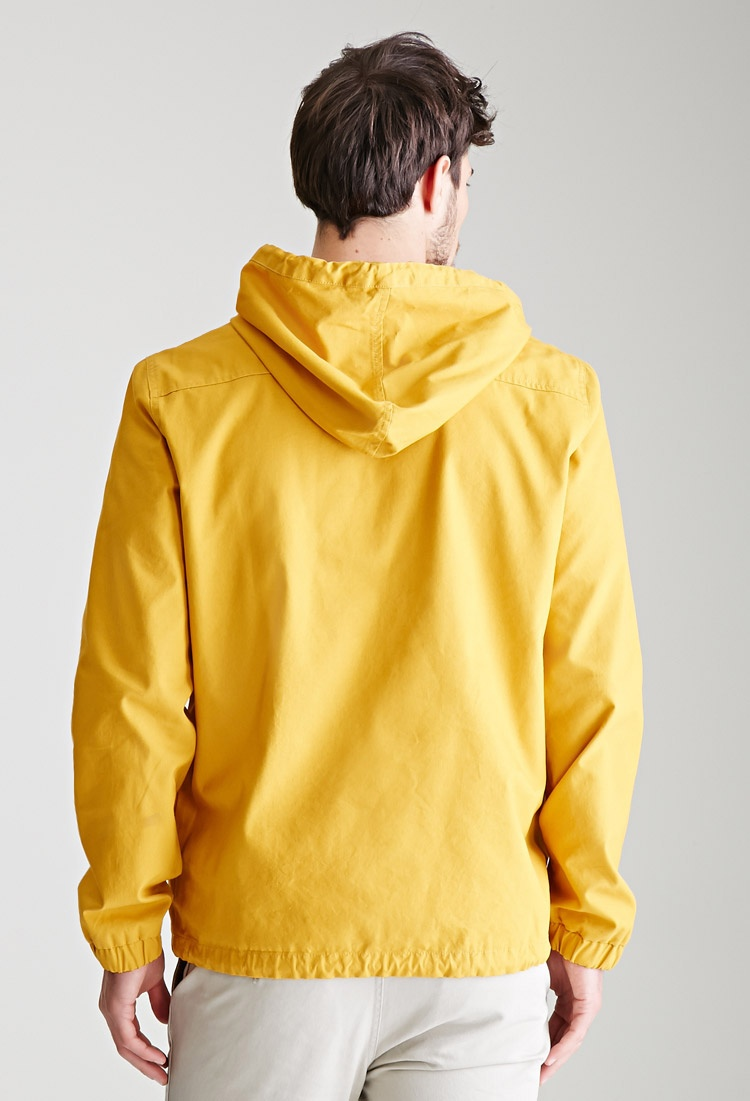

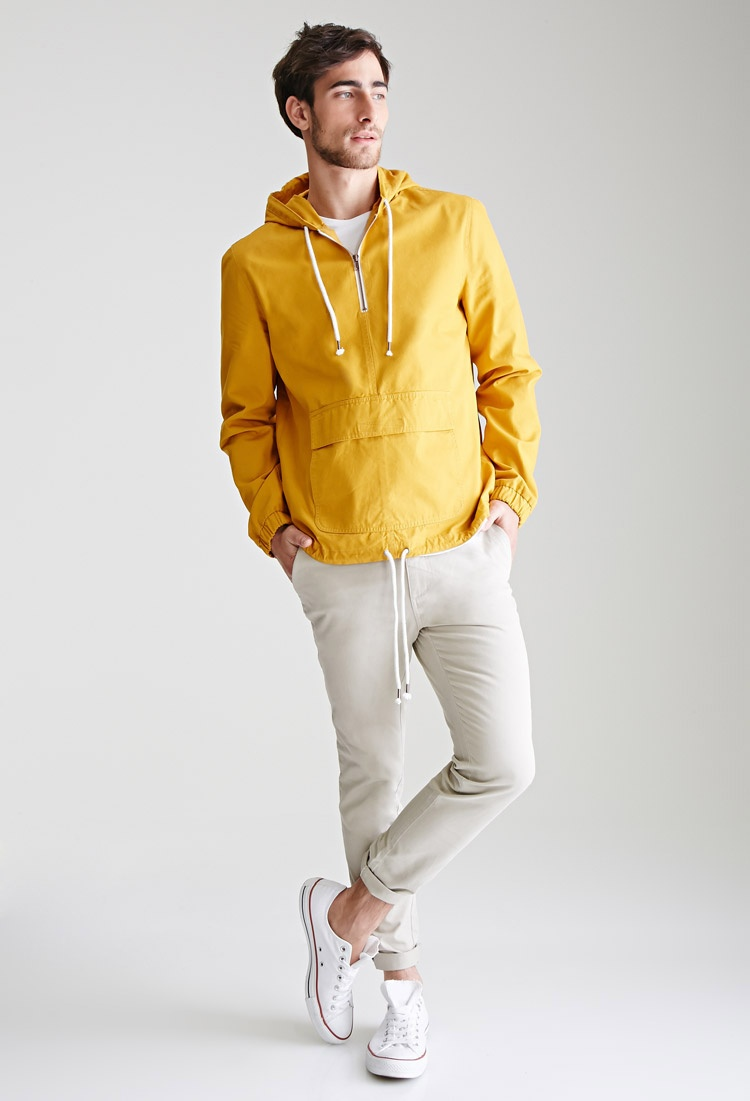

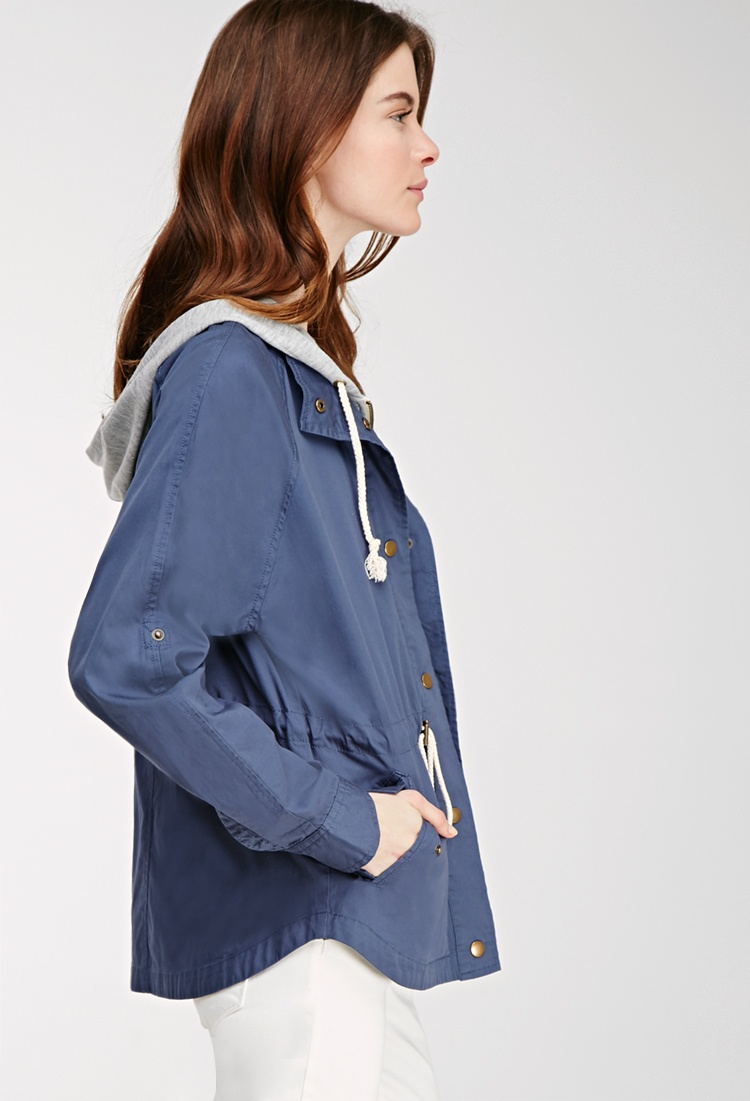

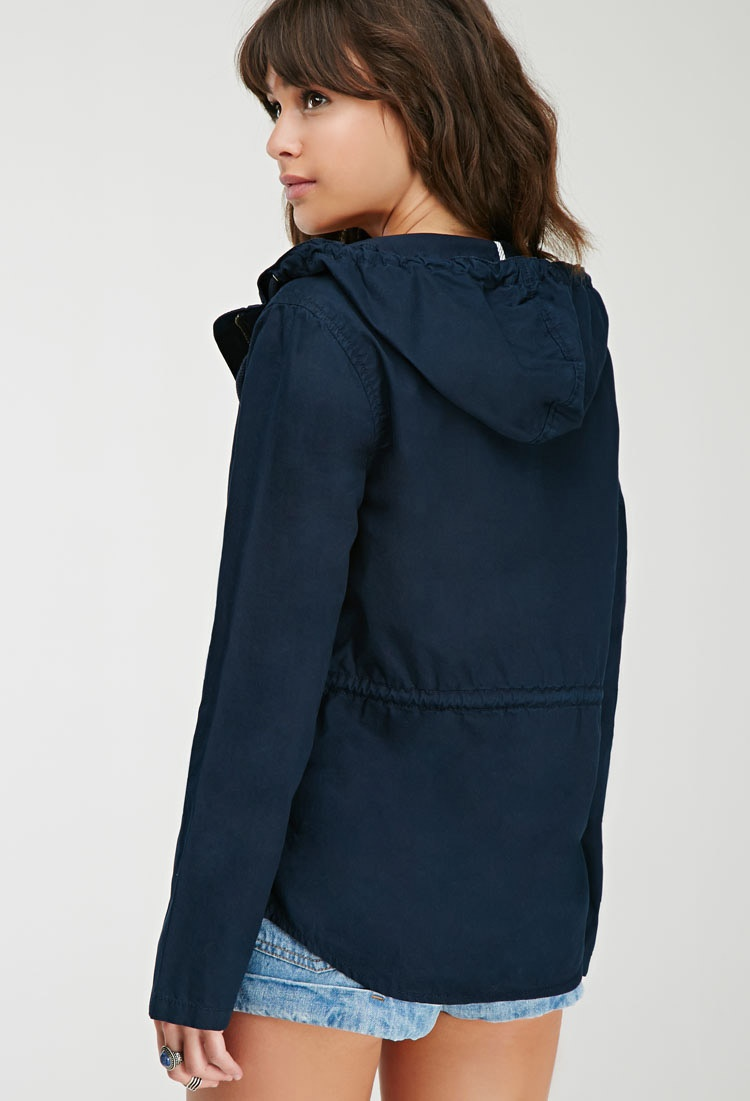

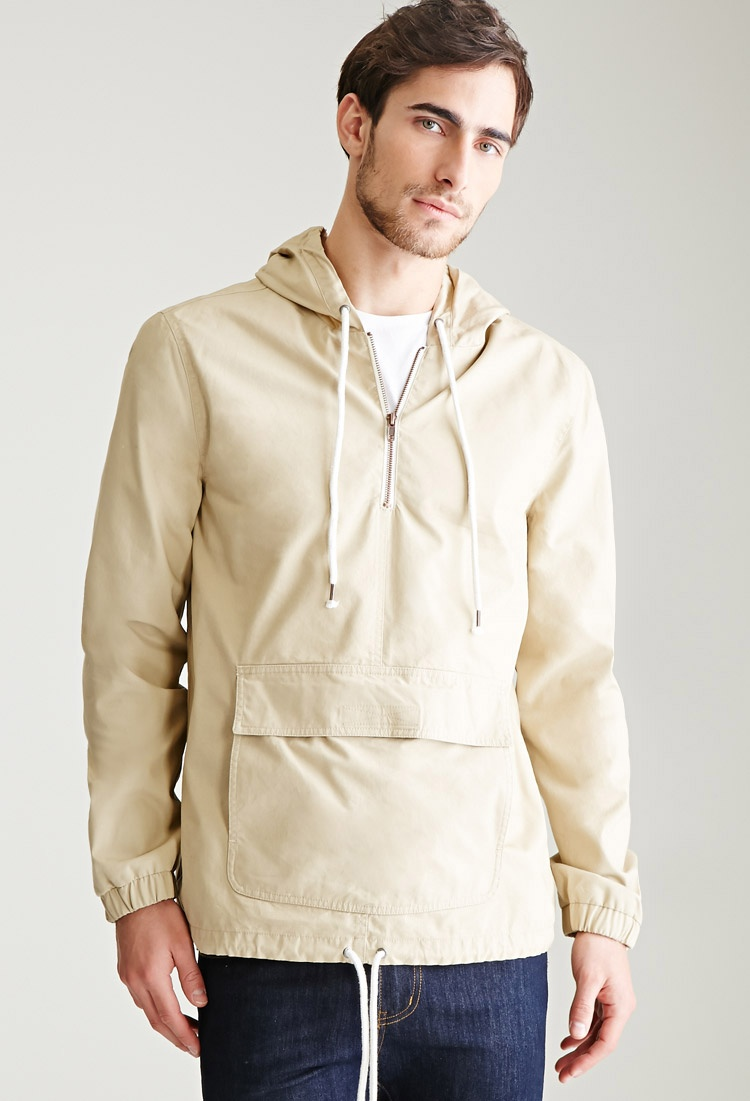

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML

# Iterate over the top 3 results
for i in range(5):
    # Retrieve the photo ID
    idx = best_photos[i][1]
    photo_id = photo_ids[idx]
    # Display the photo

    display(Image(photo_path+photo_id+".jpg"))
    
    print()
    


## <font color='5499C7'> Function </font> 


In [ ]:
# Read the photos table
#photos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone /data/unsplash/photos.tsv000', sep='\t', header=0)
photo_path ='/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion/photos/'
# Load the features and the corresponding IDs
photo_features = np.load('/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion/features/features.npy')
photo_ids = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project2/data/deepFashion/features/photo_ids.csv')
photo_ids = list(photo_ids['photo_id'])

In [ ]:
def encode_search_query(search_query):
  with torch.no_grad():
    # Encode and normalize the description using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the feature vector
  return text_encoded

In [ ]:
def find_best_matches(text_features, photo_features, photo_ids, results_count=3):
  # Compute the similarity between the descrption and each photo using the Cosine similarity
  similarities = list((text_features @ photo_features.T).squeeze(0))
 
  # Sort the photos by their similarity score
  best_photos = sorted(zip(similarities, range(photo_features.shape[0])), key=lambda x: x[0], reverse=True)

  # Return the photo IDs of the best matches
  photo_idd =[]
  for i in range(results_count):
    # Retrieve the photo ID
    idx = best_photos[i][1]
    photo_idd.append(photo_ids[idx])
 
  return photo_idd

In [ ]:
from IPython.display import Image
def display_photo(photo_id):
  display(Image(photo_path+photo_id+".jpg"))
  print()

In [ ]:
def search_unslash(search_query, photo_features, photo_ids, results_count=3):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  best_photo_ids = find_best_matches(text_features, photo_features, photo_ids, results_count)

  # Display the best photos
  for photo_id in best_photo_ids:
    display_photo(photo_id)

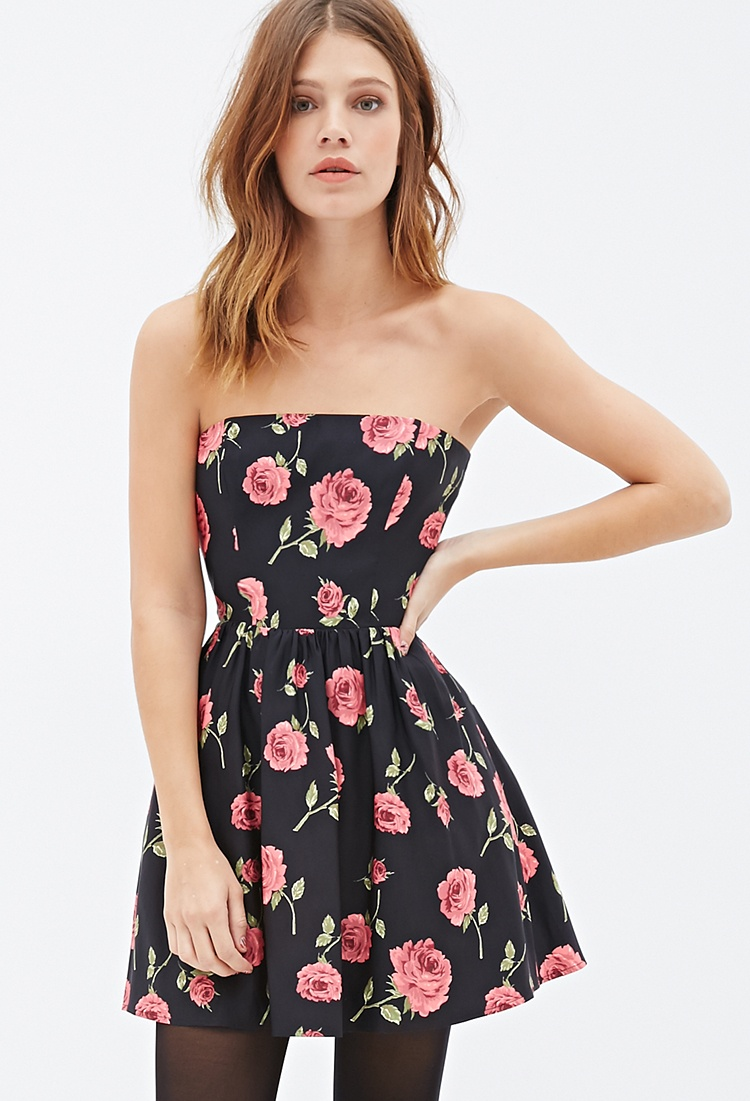

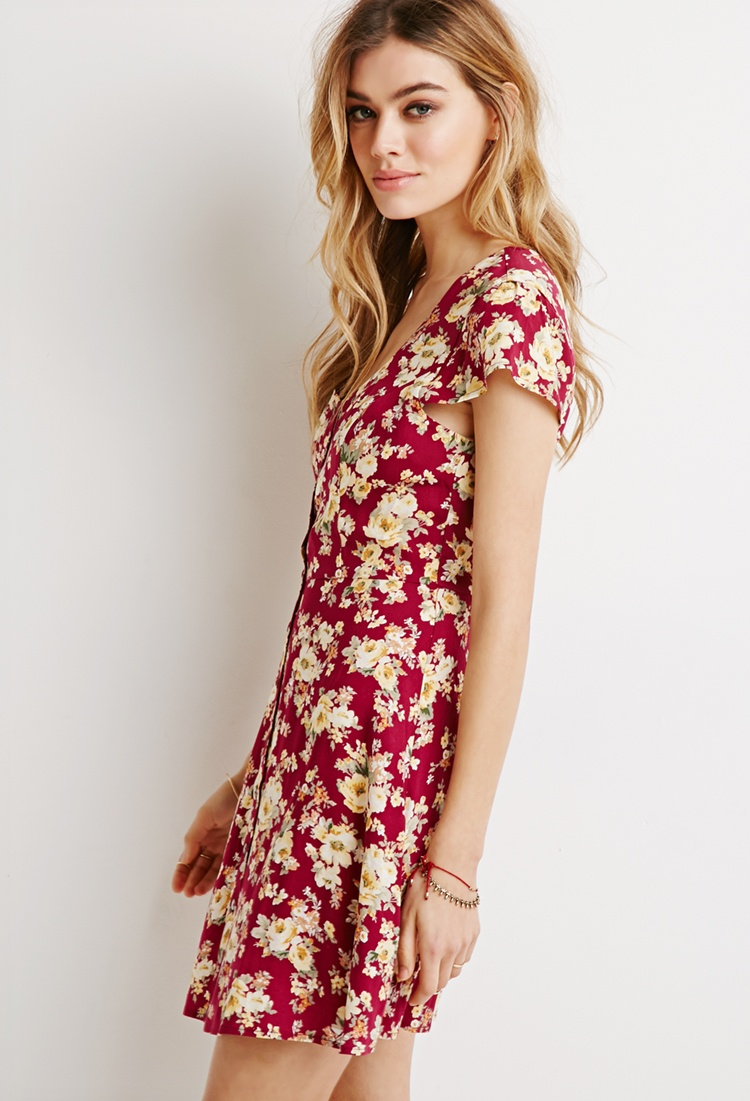

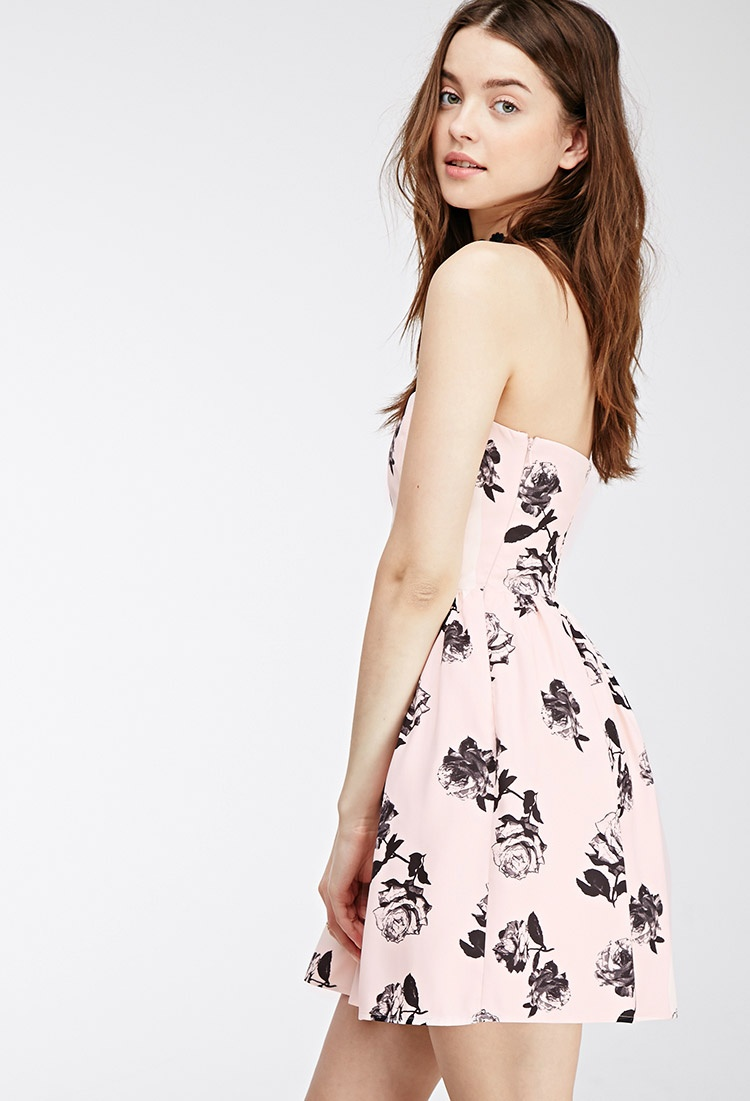

In [ ]:
search_query = "pink floral dress"

search_unslash(search_query, photo_features, photo_ids, 3)